In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

*TO DO: remove the unnecessary processing that extracts an estimate for max depth from the process-based water temperature column names. A later notebook now directly replaces this value from the TOHA lake metadata (`C_TrainTestSplits`, cell block 12).*

*TO DO: clear up some additional redundancy with `cols_to_keep` here and later usage of `vars_to_keep` in `C_TrainTestSplits`*

# Configuration

### Inputs

In [2]:
ice_obs_fpath = "../in/MN_ice/ice_duration_summarized.csv"

out_dir = "../out/"
matching_df_fpath = out_dir + "matching_sources.csv"
merged_drivers_base_fpath = out_dir + "merged_drivers/by_DOW/DOW_"
merged_drivers_suffix_fpath = "_all_vars.csv"

### Values

In [3]:
date_format = '%Y-%m-%d'
# Winter year dates determined by collaborators
# Better than water year due to water year's start being
# so close to cold seasons
winter_year_start = '-07-01'
winter_year_end = '-06-30'

# This will be expanded to include the deep water temperature and
# the depth value of that water temperature estimate
# Not included yet because deep water temperature has variable
# numeric value (whereas shallow is always "temp_0")
# temp_N_x = process based
# temp_N_y = PGDL
cols_to_keep = ['ShortWave', 'LongWave', 'AirTemp', 'RelHum',
                'WindSpeed', 'Rain', 'Snow', 'kd', 'ice',
                'rad_0', 'temp_0_x', 'temp_0_y']
warnings.warn('\n\nEnsure that `cols_to_keep` are representative of ' +
              'current drivers (excluding deep water temperature ' +
              'estimates and associated depth)\n')

C:\Users\jdiaz\AppData\Local\Temp\9/ipykernel_34452/3855319834.py:17: UserWarning: 

Ensure that `cols_to_keep` are representative of current drivers (excluding deep water temperature estimates and associated depth)

  warnings.warn('\n\nEnsure that `cols_to_keep` are representative of ' +


### Outputs

In [4]:
model_ready_data_fpath = out_dir + 'model_ready_sequences.npz'

# Import data sets

In [5]:
ice_dur = pd.read_csv(ice_obs_fpath, index_col = 0)
ice_dur

,DOW,winter.year,min_ice_on_julian,max_ice_on_julian,min_ice_on_date,max_ice_on_date,N_ice_on,range_ice_on,min_ice_off_julian,max_ice_off_julian,min_ice_off_date,max_ice_off_date,N_ice_off,range_ice_off,max_duration,min_duration
1,10000600,2018,342,342,2017-12-08,2017-12-08,1,0,121,121,2018-05-01,2018-05-01,1,0,144,144
2,10000600,2019,317,317,2018-11-13,2018-11-13,1,0,98,98,2019-04-08,2019-04-08,1,0,146,146
3,10000900,2003,337,337,2002-12-03,2002-12-03,1,0,97,97,2003-04-07,2003-04-07,1,0,125,125
4,10000900,2004,339,339,2003-12-05,2003-12-05,1,0,96,96,2004-04-05,2004-04-05,1,0,122,122
5,10000900,2005,349,349,2004-12-14,2004-12-14,1,0,96,96,2005-04-06,2005-04-06,1,0,113,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7952,9006700,2013,328,328,2012-11-23,2012-11-23,1,0,130,130,2013-05-10,2013-05-10,1,0,168,168
7953,9006700,2014,323,323,2013-11-19,2013-11-19,1,0,118,118,2014-04-28,2014-04-28,1,0,160,160
7954,9006700,2015,316,316,2014-11-12,2014-11-12,1,0,98,98,2015-04-08,2015-04-08,1,0,147,147
7955,9006700,2016,330,330,2015-11-26,2015-11-26,1,0,103,103,2016-04-12,2016-04-12,1,0,138,138


In [6]:
# ensure that the label data set doesn't have any missing values
assert ice_dur.shape == ice_dur.dropna().shape 

### Merge in that driver information from the data release (again)

In [7]:
matching_df = pd.read_csv(matching_df_fpath, index_col = 0)

# inner merge omits any lakes that do not have
# corresponding values in the both data sources
ice_dur = ice_dur.merge(matching_df,
                        how = 'inner',
                        on = 'DOW')

In [8]:
print(ice_dur.shape)
ice_dur.head()

(5104, 21)


,DOW,winter.year,min_ice_on_julian,max_ice_on_julian,min_ice_on_date,max_ice_on_date,N_ice_on,range_ice_on,min_ice_off_julian,max_ice_off_julian,...,max_ice_off_date,N_ice_off,range_ice_off,max_duration,min_duration,group,meteo_file,nhdhr,depth,area
0,10000600,2018,342,342,2017-12-08,2017-12-08,1,0,121,121,...,2018-05-01,1,0,144,144,12_N43.50-45.00_W93.50-96.75,nldas_meteo_N44.9375-44.9375_W93.5625-93.5625.csv,120020200,8.5344,992424.8
1,10000600,2019,317,317,2018-11-13,2018-11-13,1,0,98,98,...,2019-04-08,1,0,146,146,12_N43.50-45.00_W93.50-96.75,nldas_meteo_N44.9375-44.9375_W93.5625-93.5625.csv,120020200,8.5344,992424.8
2,10000900,2003,337,337,2002-12-03,2002-12-03,1,0,97,97,...,2003-04-07,1,0,125,125,12_N43.50-45.00_W93.50-96.75,nldas_meteo_N44.9375-44.9375_W93.5625-93.5625.csv,120018133,21.3360,2719879.0
3,10000900,2004,339,339,2003-12-05,2003-12-05,1,0,96,96,...,2004-04-05,1,0,122,122,12_N43.50-45.00_W93.50-96.75,nldas_meteo_N44.9375-44.9375_W93.5625-93.5625.csv,120018133,21.3360,2719879.0
4,10000900,2005,349,349,2004-12-14,2004-12-14,1,0,96,96,...,2005-04-06,1,0,113,113,12_N43.50-45.00_W93.50-96.75,nldas_meteo_N44.9375-44.9375_W93.5625-93.5625.csv,120018133,21.3360,2719879.0


# Make prediction sequences

* Cycle through all the available lakes observations...
    * Get the observed ice targets:
      * max_ice_on_date (when did ice formation most permanently begin)
      * max_ice_off_date (when did ice last disappear)
    * Read in the assembled driver data
    * Subset it the winter year of interest
    * Create a corresponding x and y model sequence
      * x = time series of assembled drivers
      * y = newly created binary sequence of ice indications with the 

In [9]:
# cur_cols_to_keep is for intermediate data subsetting
# cols_to_keep is for metadata (and will be expanded later)
cur_cols_to_keep = cols_to_keep.copy()

In [10]:
# Empty model-ready arrays to populate...

# LSTM X
all_driver_arrays = np.zeros([ice_dur.shape[0],
                              366,
                              len(cols_to_keep) + 3])

# LSTM Y
all_target_arrays = np.zeros([ice_dur.shape[0],
                              366])

# Dates corresponding to these X and Y
all_date_arrays = np.zeros([ice_dur.shape[0],
                            366]).astype(object)

# Lakes corresponding to these X and Y
all_DOW_array = np.zeros([ice_dur.shape[0]]).astype(object)

In [11]:
count = 0
for DOW in ice_dur['DOW'].unique():
    
    # get the assembled driver data associated with that lake
    driver_file = merged_drivers_base_fpath + str(DOW) + merged_drivers_suffix_fpath
    # these optional arguments (python and float) are necessary
    # to avoid a strange NAN -> 1 conversion
    lake_drivers = pd.read_csv(driver_file,
                               index_col = 0,
                               engine = 'python',
                               dtype = {'ice':float})
    
    # subset the target ice dataframe to only that lake
    sub_ice_dur = ice_dur[ice_dur['DOW'] == DOW].reset_index(drop=True)
    
    for row_i in range(sub_ice_dur.shape[0]):
        # get year
        year = sub_ice_dur['winter.year'][row_i]
        
        # if a year without driver data, fill with nans
        # TO DO: move this to a separate part of the workflow
        #        i.e., it could already be removed
        if year < 1980:
            all_driver_arrays[count] = np.repeat(np.expand_dims(np.repeat(np.nan,
                                                                          366),
                                                                1),
                                                 len(cols_to_keep) + 3,
                                                 axis = 1)
            all_target_arrays[count] = np.repeat(np.nan, 366)
            all_date_arrays[count] = np.repeat(np.nan, 366)
            all_DOW_array[count] = DOW
            count += 1
            continue
        
        # define current winter year with months
        cur_start = str(year-1) + winter_year_start
        cur_end = str(year) + winter_year_end
        
        # subset the driver data
        cur_lake_drivers = lake_drivers[(lake_drivers['date'] >= cur_start) * (lake_drivers['date'] <= cur_end)]
    
        # Subset away the intermediate depth water temperature estimates
        # only keep shallowest and deepest, also record deepest depth.
        cur_cols_to_keep = cols_to_keep.copy()
        temp_vars = [var for var in list(cur_lake_drivers) if "temp" in var]
        depths = [float(var.split("_")[1]) for var in temp_vars]
        # Max depth is variable between lakes and across years within one lake, so
        # finding and recording that depth is a little involved
        max_depth = max(depths)
        # float/int is to format the subsequent string appropriately as "_N_" or "_N.5_"
        # rather than "_N.0_"
        if (max_depth - np.round(max_depth)) == 0:
            max_depth = int(max_depth)
        # Niche situation where PB estimates go deeper than PGDL estimates
        # adjust to the lowest common depth
        while ('_x' in temp_vars[0]) and ('temp_' + str(max_depth) + '_y' not in list(cur_lake_drivers)):
                max_depth = max_depth - 0.5
        # Going 0.5m shallower for robustness
        # This is satisfactory for being NA-proof as depth changes through time
        max_depth = max_depth - 0.5
        if (max_depth - np.round(max_depth)) == 0:
            max_depth = int(max_depth)
        # FINALLY, specifying that max depth
        cur_cols_to_keep.append('temp_' + str(max_depth) + '_x')
        cur_cols_to_keep.append('temp_' + str(max_depth) + '_y')
        
        # checking if the PGDL estimates are present
        # if they are, temp_0 will have an "_x" (PB) and "_y" (PGDL)
        # if not, the PB will only be present as "temp_0"
        if 'temp_0_y' not in list(cur_lake_drivers):
            cur_lake_drivers = cur_lake_drivers.rename(columns = {'temp_0':'temp_0_x',
                                                                  ('temp_' + str(max_depth)):('temp_' + str(max_depth) + '_x')})
            # fill PGDL with NA if they have no column
            cur_lake_drivers['temp_0_y'] = np.repeat(np.nan, cur_lake_drivers.shape[0])
            cur_lake_drivers['temp_' + str(max_depth) + '_y'] = np.repeat(np.nan, cur_lake_drivers.shape[0])
    
        # get corresponding dates
        cur_dates = cur_lake_drivers['date']
        # get corresponding targets
        obs_start = sub_ice_dur['max_ice_on_date'][row_i]
        obs_end = sub_ice_dur['max_ice_off_date'][row_i]
        cur_y = ((cur_dates >= obs_start) * (cur_dates <= obs_end)).astype(float).values
        
        # get the x values
        cur_x = cur_lake_drivers[cur_cols_to_keep].values.astype(float)
        # add in depth
        cur_x = np.concatenate([cur_x,
                                np.expand_dims(np.repeat(max_depth,
                                                         cur_x.shape[0]),
                                               axis = 1)],
                               axis = 1)
        
        # Account for leap year differences
        if cur_x.shape[0] == 365:
            cur_x = np.concatenate([cur_x,
                                    np.expand_dims(np.repeat(np.nan,
                                                             cur_x.shape[1]),
                                                   axis = 0)],
                                    axis = 0)
            cur_y = np.append(cur_y, np.nan)
            cur_dates = np.append(cur_dates, np.nan)
        
        # Store
        all_driver_arrays[count] = cur_x
        all_target_arrays[count] = cur_y
        all_date_arrays[count] = cur_dates
        all_DOW_array[count] = DOW
        
        # Basic unaesthetic printing for tracking (medium length code)
        if count % 100 == 0:
            print(count)
        count += 1

0
100
200
300
400
600
700
800
900
1000
1200
1300
1400
1500
1600
1700
1900
2000
2100
2200
2400
2500
2600
2700
2800
2900
3000
3200
3300
3500
3600
3700
3800
3900
4100
4300
4500
4600
4700
4800
5000
5100


In [12]:
# Formally add those extra columns
cols_to_keep.append('temp_MaxDepth_x')
cols_to_keep.append('temp_MaxDepth_y')
cols_to_keep.append('MaxDepth')

assert(len(cols_to_keep) == all_driver_arrays.shape[-1])

In [13]:
# Lump the sequenced objects (drivers, targets, dates, lakes, variables) together
# so they're accessible when doing modeling or eval work
data = {'x':all_driver_arrays,
        'y':all_target_arrays,
        'dates':all_date_arrays,
        'DOW':all_DOW_array,
        'features':cols_to_keep}

np.savez_compressed(model_ready_data_fpath, **data)

<br><br><br>

### View some interesting driver sequences (ice flag column)

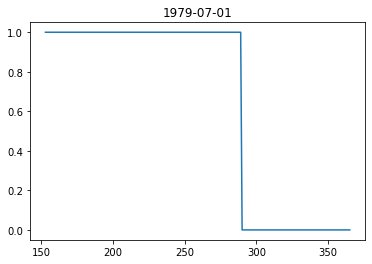

In [14]:
plt.plot(all_driver_arrays[2199, :, 8])
plt.title(all_date_arrays[2199, 0]);

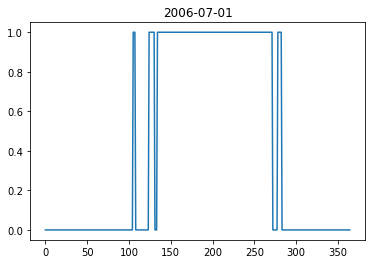

In [15]:
plt.plot(all_driver_arrays[4560, :, 8])
plt.title(all_date_arrays[4560, 0]);

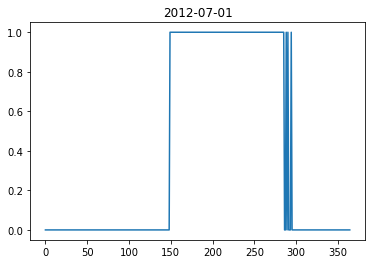

In [16]:
plt.plot(all_driver_arrays[4887, :, 8])
plt.title(all_date_arrays[4887, 0]);